# Clustering Proteins with ESM-2 and Persistent Homology

This notebook will focus on analyzing protein sequences using a transformer model called ESM-2 from Facebook AI. We'll use the attention matrices from the transformer model to compute Jensen-Shannon distance matrices. Then, we'll compute persistent homology diagrams using the Gudhi library. Finally, we'll cluster these diagrams using various clustering algorithms.

In [1]:
# Let's start by importing necessary libraries
from transformers import EsmModel, AutoTokenizer
import gudhi as gd
import numpy as np
import torch
from scipy.spatial.distance import pdist, jensenshannon, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from gudhi.hera import wasserstein_distance

Now, let's define some helper functions for our analysis.

In [2]:
# Helper function to get the attention matrix of a specific layer and head for a given input sequence
def get_attention_matrix(tokenizer, model, layer, head, input_sequence):
    model.config.output_attentions = True
    encoded_input = tokenizer([input_sequence], return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        model_output = model(**encoded_input)
    attention_weights = model_output.attentions
    specific_attention_weights = attention_weights[layer][0, head]
    return specific_attention_weights

# Helper function to compute the Jensen-Shannon distance matrix
def compute_js_distance_matrix_scipy(attention_matrix):
    js_distances = pdist(attention_matrix, metric=jensenshannon)
    js_distance_matrix = squareform(js_distances)
    return js_distance_matrix

# Helper function to compute the persistent homology of a given distance matrix
def compute_persistent_homology(distance_matrix, max_dimension=3):
    max_edge_length = np.max(distance_matrix)
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_edge_length)
    st = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    persistence = st.persistence()
    return st, persistence

# Helper function to compute the Wasserstein distances between all pairs of persistence diagrams
def compute_wasserstein_distances(persistence_diagrams, dimension):
    n_diagrams = len(persistence_diagrams)
    distances = np.zeros((n_diagrams, n_diagrams))
    filtered_diagrams = [[point for point in diagram if point[0] == dimension] for diagram in persistence_diagrams]
    for i in range(n_diagrams):
        for j in range(i+1, n_diagrams):
            X = np.array([p[1] for p in filtered_diagrams[i]])
            Y = np.array([p[1] for p in filtered_diagrams[j]])
            distance = wasserstein_distance(X, Y)
            distances[i][j] = distance
            distances[j][i] = distance
    return distances


With our helper functions ready, let's now load our transformer model and tokenizer.

In [3]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's compute the attention matrix, Jensen-Shannon distance matrix, and persistent homology for a sample protein sequence.

In [4]:
# Define layer and head to be used
layer = 3
head = 2

# Define a sample protein sequence
input_sequence = "GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG"

# Compute the attention matrix
attention_matrix = get_attention_matrix(tokenizer, model, layer, head, input_sequence)

# Compute the Jensen-Shannon distance matrix
distance_matrix = compute_js_distance_matrix_scipy(attention_matrix)

# Compute the persistent homology
# max_dimension = 4 may take several minutes
# max_dimension = bigger number means the computation will take longer
st, persistence = compute_persistent_homology(distance_matrix, max_dimension=3)


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

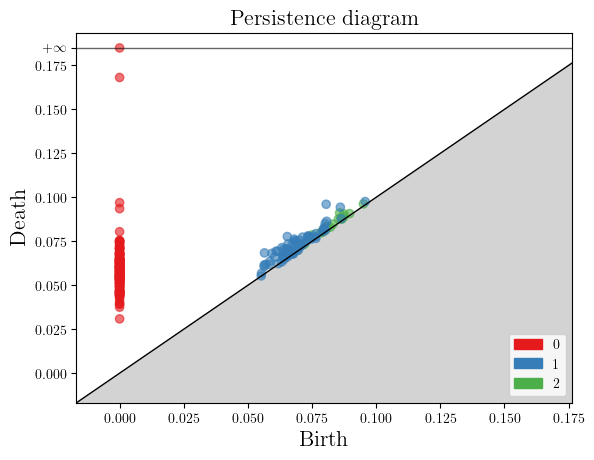

In [5]:
gd.plot_persistence_diagram(persistence)

Now that we've computed the persistent homology for our sample sequence, let's compute it for a list of protein sequences.

In [6]:
# Define a list of protein sequences
sequences = [
    # Protein family 1: Cytochrome C
    "GDVEKGKKIFIMKCSQCHTVEKGGKHKTGPNLHGLFGRKTGQAPGYSYTAANKNKGIIWGEDTLMEYLENPKKYIPGTKMIFVGIKKKEERADLIAYLKKATNE",
    "GDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAPGFTYTDANKNKGITWKEETLMEYLENPKKYIPGTKMIFAGIKKKTEREDLIAYLKKATNE",
    "GDVEKGKKIFVQKCAQCHTVEKGGKHKTGPNLHGLFGRKTGQAPGFTYTDANKNKGITWGEDTLMEYLENPKKYIPGTKMIFAGIKKKTEREDLIAYLKKATNE",

    # Protein family 2: Ubiquitin
    "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG",
    "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGC",
    "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGCC",

    # Protein family 3: Alpha-lactalbumin
    "MKCLLLALALTCGAQALIVTQTMKGLDIQKVAGTWYSLAMAASDISLLDAQSAPLRVYVEELKPTPEGDLEILLQKWENGECAQKKIIAEKTKIPAVFKIDALNKDKYKNIGK",
    "MKCLLLALALTCGAQALIVTQTMKGLDIQKVAGTWYSLAMAASDISLLDAQSAPLRVYVEELKPTPEGDLEILLQKWENGECAQKKIIAEKTKIPAVFKIDALNKDKYKNIGKL",
    "MKCLLLALALTCGAQALIVTQTMKGLDIQKVAGTWYSLAMAASDISLLDAQSAPLRVYVEELKPTPEGDLEILLQKWENGECAQKKIIAEKTKIPAVFKIDALNKDKYKNIGKLN",

    # Protein family 4: Lysozyme
    "KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL",
    "KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRLN",
    "KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRLNS",

    # Protein family 5: Myoglobin
    "GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG",
    "GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQGF",
    "GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQGFS"
]



# Initialize list to store persistent diagrams
persistent_diagrams = []

# Compute persistent homology for each sequence
for sequence in sequences:
    attention_matrix = get_attention_matrix(tokenizer, model, layer, head, sequence)
    distance_matrix = compute_js_distance_matrix_scipy(attention_matrix.numpy())
    _, persistence_diagram = compute_persistent_homology(distance_matrix)
    
    # Store the persistent diagram
    persistent_diagrams.append(persistence_diagram)


With persistent diagrams in hand, we can now compute the Wasserstein distances between all pairs of persistence diagrams, which provide a measure of similarity between the diagrams.

In [23]:
# Compute the Wasserstein distances between all pairs of persistence diagrams
wasserstein_distances = compute_wasserstein_distances(persistent_diagrams, 1)

Next, compute the persistent homology of the Wasserstein distance matrix. We already have a helper function compute_persistent_homology for this.

In [24]:
# Compute the persistent homology of the Wasserstein distance matrix
st_2, persistence_2 = compute_persistent_homology(wasserstein_distances)


Next, plot the persistence diagram using the Gudhi library.

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

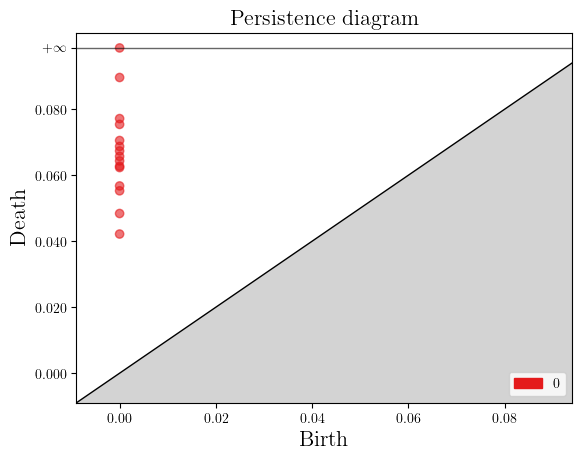

In [25]:
# Plot the persistence diagram
gd.plot_persistence_diagram(persistence_2)


Finally, we can use various clustering algorithms to group similar protein sequences together based on their persistence diagrams.

In [51]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(wasserstein_distances)
labels_kmeans = kmeans.labels_
print("Silhouette Coefficient for KMeans: %0.3f" % silhouette_score(wasserstein_distances, labels_kmeans))

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='average').fit(wasserstein_distances)
labels_agg = agg_clustering.labels_
print("Silhouette Coefficient for Agglomerative Clustering: %0.3f" % silhouette_score(wasserstein_distances, labels_agg))

# Perform DBSCAN clustering
dbscan = DBSCAN(metric="precomputed", eps=0.075, min_samples=1).fit(wasserstein_distances)
labels_dbscan = dbscan.labels_
if len(set(labels_dbscan)) > 1:  # More than 1 cluster
    print("Silhouette Coefficient for DBSCAN: %0.3f" % silhouette_score(wasserstein_distances, labels_dbscan))
else:
    print("Cannot compute Silhouette Coefficient for DBSCAN as there is only one cluster.")


Silhouette Coefficient for KMeans: 0.289
Silhouette Coefficient for Agglomerative Clustering: 0.289
Silhouette Coefficient for DBSCAN: 0.255


/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [52]:
# Print the clusters for KMeans
print("Clusters for KMeans:")
kmeans_clusters = {i: [] for i in set(labels_kmeans)}
for sequence, label in zip(sequences, labels_kmeans):
    kmeans_clusters[label].append(sequence)
for label, cluster in kmeans_clusters.items():
    print(f"Cluster {label}: {cluster}")

# Print the clusters for Agglomerative Clustering
print("\nClusters for Agglomerative Clustering:")
agg_clusters = {i: [] for i in set(labels_agg)}
for sequence, label in zip(sequences, labels_agg):
    agg_clusters[label].append(sequence)
for label, cluster in agg_clusters.items():
    print(f"Cluster {label}: {cluster}")

# Print the clusters for DBSCAN
print("\nClusters for DBSCAN:")
dbscan_clusters = {i: [] for i in set(labels_dbscan)}
for sequence, label in zip(sequences, labels_dbscan):
    dbscan_clusters[label].append(sequence)
for label, cluster in dbscan_clusters.items():
    print(f"Cluster {label}: {cluster}")


Clusters for KMeans:
Cluster 0: ['GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG', 'GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQGF', 'GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQGFS']
Cluster 1: ['MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG', 'MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGC', 'MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGCC']
Cluster 2: ['KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKKIVSDGNGMNAWVAWRNRCKGTDVQAWIRGCRL', 'KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASV

To compare the clusters given by different clustering algorithms, we can use a measure called the Adjusted Rand Index (ARI). The ARI is a function that measures the similarity of the two assignments, ignoring permutations and with chance normalization. The maximum ARI score is 1, indicating that the two sets of clusters are identical. Next, we can calculate the ARI for each pair of clustering results:

In [53]:
from sklearn.metrics import adjusted_rand_score

# Calculate ARIs
ari_kmeans_agg = adjusted_rand_score(labels_kmeans, labels_agg)
ari_kmeans_dbscan = adjusted_rand_score(labels_kmeans, labels_dbscan)
ari_agg_dbscan = adjusted_rand_score(labels_agg, labels_dbscan)

# Print ARIs
print(f"Adjusted Rand Index for KMeans and Agglomerative Clustering: {ari_kmeans_agg}")
print(f"Adjusted Rand Index for KMeans and DBSCAN: {ari_kmeans_dbscan}")
print(f"Adjusted Rand Index for Agglomerative Clustering and DBSCAN: {ari_agg_dbscan}")


Adjusted Rand Index for KMeans and Agglomerative Clustering: 1.0
Adjusted Rand Index for KMeans and DBSCAN: 0.72
Adjusted Rand Index for Agglomerative Clustering and DBSCAN: 0.72


The ARI scores will give you a measure of the similarity between the clusters found by the different algorithms. Please note that while the ARI can give a general sense of the similarity between different sets of clusters, it doesn't provide a detailed comparison of the clusters. For example, it won't tell you which specific clusters in one algorithm correspond to the clusters in another algorithm. To do that, you'd need to look more closely at the specific elements in each cluster and see where they appear in the other set of clusters.